<a href="https://colab.research.google.com/github/OpenMLCo/TensorRT-Yolo-Deepsort/blob/main/Cambio_de_fondo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cambio de fondo final

In [1]:
!pip install pyyaml==5.1
import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 6.6 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=d78d0573647244cedd1a9ce6e6663bb33c855a01d5c836d80bcaca824196766f
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
torch:  1.10 ; cuda:  cu111
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.10/index.html
     |████████████████████████████████| 7.0 MB 5.3 MB/s 
     |████████████████████████████████| 55 kB 3.0 MB/s 
     |████████████████████████████████| 74 kB 3.2 MB/s 
     |████████████████████████████████| 130 kB 66.0 MB/s 
     |████████████████████████████████| 145 kB 67.5 MB/s 
     |████████████████████████████████| 748 kB 66.8 MB/s 
     |███████████████████████████████

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/OpenMLCo/La_victoria_Caldas_jetson_nano/Codes_Victoria_vision/Matting image'

/content/drive/.shortcut-targets-by-id/1GipOC8Hz3e8AtmT9OmZTTsRd2lSIVq8A/Codes_Victoria_vision/Matting image


In [4]:
ls

backgroun.jpeg               person.jpg  tales.jpg   trimap.png
Deep-Image-Matting-PyTorch/  person.png  trimap.jpg


In [5]:
#!git clone https://github.com/foamliu/Deep-Image-Matting-PyTorch.git
%cd Deep-Image-Matting-PyTorch/

/content/drive/.shortcut-targets-by-id/1GipOC8Hz3e8AtmT9OmZTTsRd2lSIVq8A/Codes_Victoria_vision/Matting image/Deep-Image-Matting-PyTorch


In [6]:
import math

import random
import cv2 as cv
import numpy as np
import torch
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt

from config import device, fg_path_test, a_path_test, bg_path_test
from data_gen import data_transforms, fg_test_files, bg_test_files
from utils import compute_mse, compute_sad, AverageMeter, get_logger
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # sets device for model and PyTorch tensors

im_size = 320
unknown_code = 128
epsilon = 1e-6
epsilon_sqr = epsilon ** 2

num_samples = 43100
num_train = 34480
# num_samples - num_train_samples
num_valid = 8620

# Training parameters
num_workers = 1  # for data-loading; right now, only 1 works with h5py
grad_clip = 5.  # clip gradients at an absolute value of
print_freq = 100  # print training/validation stats  every __ batches
checkpoint = None  # path to checkpoint, None if none

##############################################################
# Set your paths here

# path to provided foreground images
fg_path = 'data/fg/'

# path to provided alpha mattes
a_path = 'data/mask/'

# Path to background images (MSCOCO)
bg_path = 'data/bg/'

# Path to folder where you want the composited images to go
out_path = 'data/merged/'

max_size = 1600
fg_path_test = 'data/fg_test/'
a_path_test = 'data/mask_test/'
bg_path_test = 'data/bg_test/'
out_path_test = 'data/merged_test/'
##############################################################
import time
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

def gen_test_names():
    num_fgs = 50
    num_bgs = 1000
    num_bgs_per_fg = 20

    names = []
    bcount = 0
    for fcount in range(num_fgs):
        for i in range(num_bgs_per_fg):
            names.append(str(fcount) + '_' + str(bcount) + '.png')
            bcount += 1

    return names


def process_test(im_name, bg_name, trimap):
    # print(bg_path_test + bg_name)
    im = cv.imread(im_name)
    a = cv.imread(im_name, 0)
    h, w = im.shape[:2]
    bg = cv.imread(bg_name)
    bh, bw = bg.shape[:2]
    wratio = w / bw
    hratio = h / bh
    ratio = wratio if wratio > hratio else hratio
    if ratio > 1:
        bg = cv.resize(src=bg, dsize=(math.ceil(bw * ratio), math.ceil(bh * ratio)), interpolation=cv.INTER_CUBIC)

    return composite4_test(im, bg, a, w, h, trimap)

def composite4(fg, bg, a, w, h):
    print(fg.shape, bg.shape, a.shape, w, h)
    fg = np.array(fg, np.float32)
    bg_h, bg_w = bg.shape[:2]
    x = 0
    if bg_w > w:
        x = np.random.randint(0, bg_w - w)
    y = 0
    if bg_h > h:
        y = np.random.randint(0, bg_h - h)
    bg = np.array(bg[y:y + h, x:x + w], np.float32)
    alpha = np.zeros((h, w, 1), np.float32)
    alpha[:, :, 0] = a
    im = alpha * fg + (1 - alpha) * bg
    im = im.astype(np.uint8)
    return im, bg

# def composite4_test(fg, bg, a, w, h):
#     fg = np.array(fg, np.float32)
#     bg_h, bg_w = bg.shape[:2]
#     x = max(0, int((bg_w - w)/2))
#     y = max(0, int((bg_h - h)/2))
#     bg = np.array(bg[y:y + h, x:x + w], np.float32)
#     alpha = np.zeros((h, w, 1), np.float32)
#     alpha[:, :, 0] = a / 255.
#     im = alpha * fg + (1 - alpha) * bg
#     im = im.astype(np.uint8)
#     print('im.shape: ' + str(im.shape))
#     print('a.shape: ' + str(a.shape))
#     print('fg.shape: ' + str(fg.shape))
#     print('bg.shape: ' + str(bg.shape))
#     return im, a, fg, bg

def gen_trimap(alpha):
    k_size = random.choice(range(1, 5))
    iterations = np.random.randint(1, 20)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (k_size, k_size))
    dilated = cv.dilate(alpha, kernel, iterations)
    eroded = cv.erode(alpha, kernel, iterations)
    trimap = np.zeros(alpha.shape)
    trimap.fill(128)
    trimap[eroded >= 255] = 255
    trimap[dilated <= 0] = 0
    return trimap

def semantic_segmentation(im_name):
    im = cv.imread(im_name)
    cfg = get_cfg()
    # add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
    # Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    predictor = DefaultPredictor(cfg)
    prev_2=time.time()
    outputs = predictor(im)
    #v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
    #out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    #imagen = out.get_image()[:, :, ::-1]
    #cv2.imwrite('Imagen_result_person.jpg',imagen)
    rr=outputs["instances"].to("cpu")
    for i,mask in enumerate(rr.pred_masks):
        return (255*mask.numpy()).astype(np.uint8)
def composite4_test(fg, bg, a, w, h, trimap):
    fg = np.array(fg, np.float32)
    bg_h, bg_w = bg.shape[:2]
    x = max(0, int((bg_w - w) / 2))
    y = max(0, int((bg_h - h) / 2))
    crop = np.array(bg[y:y + h, x:x + w], np.float32)
    alpha = np.zeros((h, w, 1), np.float32)
    alpha[:, :, 0] = a / 255.
    # trimaps = np.zeros((h, w, 1), np.float32)
    # trimaps[:,:,0]=trimap/255.

    im = alpha * fg + (1 - alpha) * crop
    im = im.astype(np.uint8)

    new_a = np.zeros((bg_h, bg_w), np.uint8)
    new_a[y:y + h, x:x + w] = a
    new_trimap = np.zeros((bg_h, bg_w), np.uint8)
    new_trimap[y:y + h, x:x + w] = trimap
    cv.imwrite('images/test/new/tripmap_new.png', new_trimap)
    new_im = bg.copy()
    new_im[y:y + h, x:x + w] = im
    # cv.imwrite('images/test/new_im/'+trimap_name,new_im)
    return new_im, new_a, fg, bg, new_trimap, y, y + h, x, x + w

In [7]:
checkpoint = 'BEST_checkpoint.tar'
checkpoint = torch.load(checkpoint)
model = checkpoint['model'].module
model = model.to(device)
model.eval()
transformer = data_transforms['valid']

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.parallel.data_parallel.DataParallel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.container.Sequential' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attri

In [8]:
im_name = '/content/drive/MyDrive/OpenMLCo/La_victoria_Caldas_jetson_nano/Codes_Victoria_vision/Matting image/person.jpg'
bg_name = '/content/drive/MyDrive/OpenMLCo/La_victoria_Caldas_jetson_nano/Codes_Victoria_vision/Matting image/backgroun.jpeg'
mask = semantic_segmentation(im_name)
kernel = np.ones((10, 10), np.uint8)
foreground = cv.erode(mask, kernel,3)
kernel = np.ones((10, 10), np.uint8)
nose = cv.dilate(mask, kernel)
nose = nose-foreground
trimap = foreground+nose*0.5
trimapa=trimap.astype(np.uint8)

model_final_f10217.pkl: 178MB [00:01, 93.6MB/s]                          
/usr/local/lib/python3.7/dist-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [9]:
#trimap = cv.imread('/content/drive/MyDrive/OpenMLCo/La_victoria_Caldas_jetson_nano/Codes_Victoria_vision/Matting image/trimap.png', 0)
img, alpha, fg, bg, new_trimap,y_2,yh, x_2,xw = process_test(im_name, bg_name, trimapa)

In [10]:
h, w = img.shape[:2]
trimap = gen_trimap(alpha)
# mytrimap = gen_trimap(alpha)
# cv.imwrite('images/test/new_im/'+trimap_name,mytrimap)

x = torch.zeros((1, 4, h, w), dtype=torch.float)
img = img[..., ::-1]  # RGB
img = transforms.ToPILImage()(img)  # [3, 320, 320]
img = transformer(img)  # [3, 320, 320]
x[0:, 0:3, :, :] = img
x[0:, 3, :, :] = torch.from_numpy(new_trimap.copy() / 255.)

# Move to GPU, if available
x = x.type(torch.FloatTensor).to(device)  # [1, 4, 320, 320]
alpha = alpha / 255.

with torch.no_grad():
    pred = model(x)  # [1, 4, 320, 320]

pred = pred.cpu().numpy()
pred = pred.reshape((h, w))  # [320, 320]

pred[new_trimap == 0] = 0.0
pred[new_trimap == 255] = 1.0
#cv.imwrite('/content/drive/MyDrive/La_victoria_Caldas_jetson_nano/Codes_Victoria_vision/Matting image/tales.jpg', pred * 255)


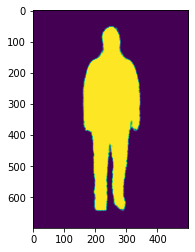

In [11]:
plt.imshow(pred)

In [12]:
im_i= cv.imread(im_name)
bg_i=   cv.imread(bg_name)
im_i_rgb = cv.cvtColor(im_i, cv.COLOR_BGR2RGB)
bg_i_rgb = cv.cvtColor(bg_i, cv.COLOR_BGR2RGB)

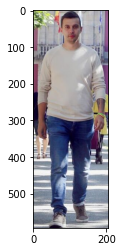

In [13]:
plt.imshow(im_i_rgb)

In [14]:
pred_3d = pred[:,:,np.newaxis]

In [15]:
final = bg_i
final[y_2:yh, x_2:xw] = bg_i[y_2:yh, x_2:xw]*(1-pred_3d[y_2:yh, x_2:xw])+im_i*(pred_3d[y_2:yh, x_2:xw])
final=final.astype(np.uint8)
cv.imwrite('/content/drive/MyDrive/La_victoria_Caldas_jetson_nano/Codes_Victoria_vision/Matting image/tales.jpg',final)
final_rgb = cv.cvtColor(final, cv.COLOR_BGR2RGB)

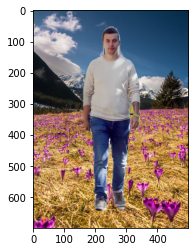

In [16]:
plt.imshow(final_rgb)